In [2]:
import pandas as pd
import numpy as np
import biom
from qiime2 import Artifact
import seaborn as sns
import os
import json
from matplotlib import pyplot as plt
from q2_mlab import ParameterGrids, RegressionTask, ClassificationTask
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse
from itertools import product
%config InlineBackend.figure_format = 'retina' # 'svg'

These figures and the null models describe the metadata (target variable values) of each dataset.
Point to the metadata in the cell below:

In [6]:
basedir = "/projects/ibm_aihl/ML-benchmark/processed/"
# 16S and MG have >95% overlap (shared samples). We use the 16S metadata to represent the datasets.
level = "16S" 
# Column names for age and BMI are inconsistent between datasets, so we adjust for those here.
canonical_targets = ["age", "bmi"]

In [7]:
def merge_normalize_metadata(basedir, level, canonical_targets):
    target_mapping = {
        'age_v2': 'age',
        'BL_AGE': 'age',
        'bmi_v2': 'bmi',
        'BMI': 'bmi',
        'bmi': 'bmi',
        'age': 'age'
    }

    datasets_to_target = {
        "finrisk": ["BL_AGE", "BMI"],
        "sol": ["age_v2", "bmi_v2"],
        "imsms": ["age", "bmi"],
    }
    all_metadata = []
    for dataset in datasets_to_target:   
        for target in datasets_to_target[dataset]:

            metadata = Artifact.load(
                os.path.join(basedir, f"{dataset}/{level}/{target}/filtered_metadata.qza")
            ).view(pd.Series)
            metadata = metadata.to_frame()
            metadata["dataset"] = dataset

            # Normalize target names
            canon_target = target_mapping[target]
            if target not in canonical_targets:
                metadata[canon_target] = metadata[target]
                metadata = metadata.drop([target], axis=1)
           
            stdev = np.std(metadata[canon_target])
            print(dataset, canon_target, stdev) # sample stdev
            metadata["stdev_" + canon_target] = stdev
            all_metadata.append(metadata)

    df = pd.concat(all_metadata)
    df = df.fillna('')
    combined = []
    for target in canonical_targets:
        targetdf = df[df[target]!=''].drop(
            list(filter(lambda x: x != target, canonical_targets)), 
            axis=1
        )
        targetdf[target] = targetdf[target].astype("float")
        combined.append(targetdf)
    df = pd.concat(combined, axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    return df

In [8]:
merged_metadata = merge_normalize_metadata(basedir, level, canonical_targets)
merged_metadata

finrisk age 12.984428438908639
finrisk bmi 4.687526024825324
sol age 11.125794964736535
sol bmi 5.785418158675929
imsms age 12.583863483564011
imsms bmi 5.297300501256507


,age,dataset,stdev_age,stdev_bmi,bmi
820003753-8,57.92,finrisk,12.9844,,49.586777
820003769-1,69.13,finrisk,12.9844,,43.784054
820003785-0,71.73,finrisk,12.9844,,23.035957
820003801-3,68.04,finrisk,12.9844,,39.421661
820003817-9,60.38,finrisk,12.9844,,27.896684
...,...,...,...,...,...
S.71802.0057.2.2.17,33.00,imsms,12.5839,,16.161616
S.71802.0058.2.2.17,47.00,imsms,12.5839,,33.240837
S.71802.0059.N.A,60.00,imsms,12.5839,,28.196921
S.71802.0064.2.21.17,38.00,imsms,12.5839,,29.411765


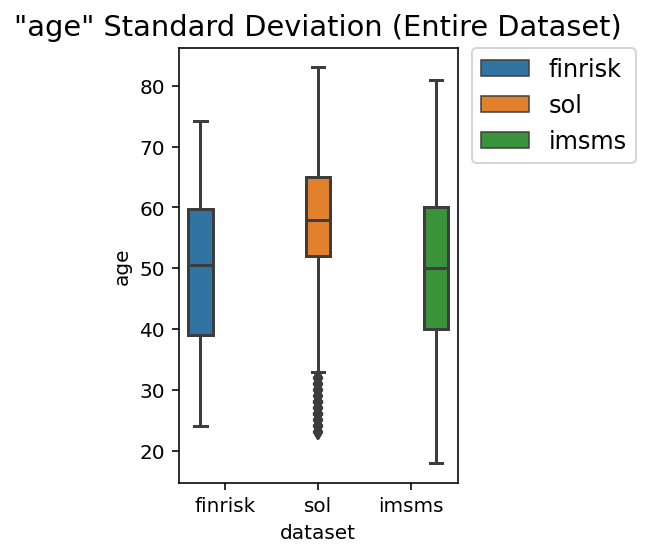

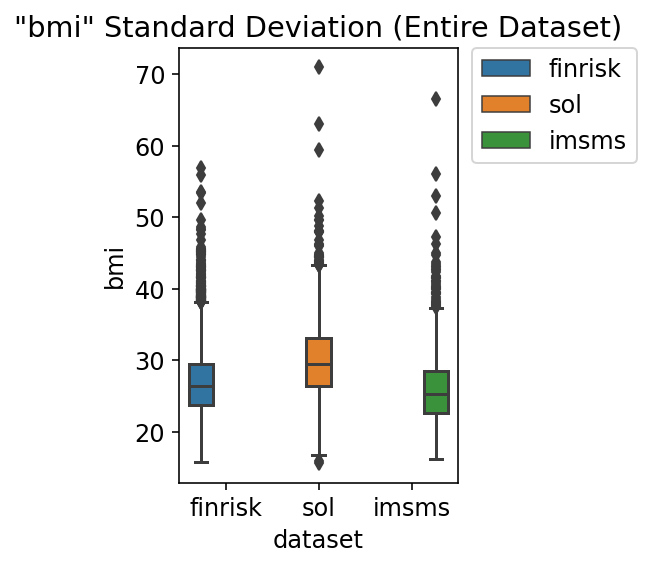

In [9]:
for target in canonical_targets:
    fig, ax = plt.subplots()
    fig.set_size_inches(2.5, 4)

    plt.rc('font', size=12)   
    sns.boxplot(
        data = merged_metadata, 
        y=target,
        x="dataset",
        hue="dataset",
        ax=ax
    ).set_title(f"\"{target}\" Standard Deviation (Entire Dataset)")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

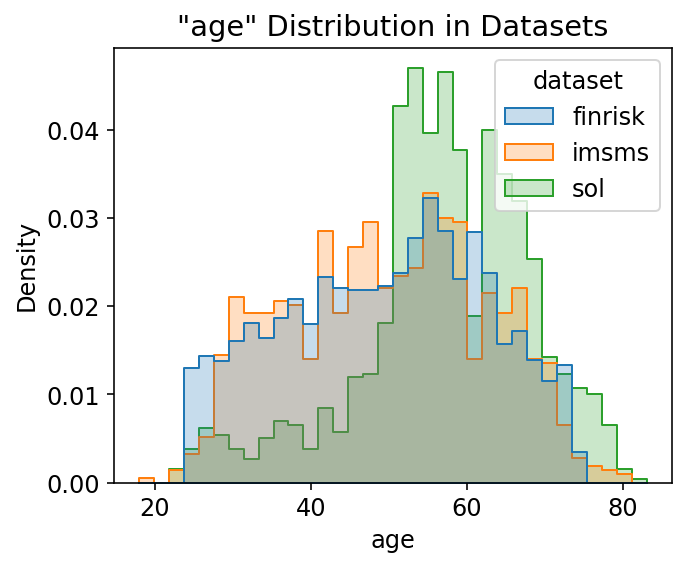

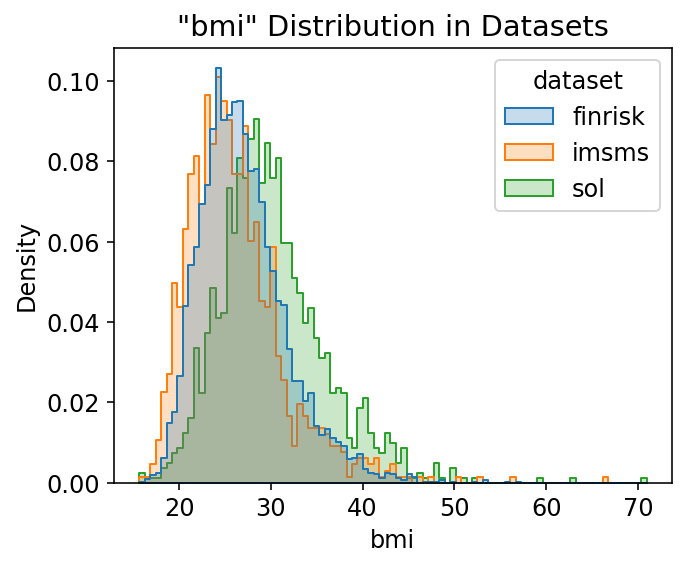

In [10]:
for target in canonical_targets:
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 4)

    plt.rc('font', size=12)   
    sns.histplot(
        data = merged_metadata, 
        x=target,
        hue="dataset",
        hue_order=["finrisk", "imsms", "sol"],
        kde=False, 
        element="step",
        stat="density", 
        common_norm=False,
        ax=ax,
    ).set_title(f"\"{target}\" Distribution in Datasets")
    

In [11]:
melted_metadata = merged_metadata.melt(
    id_vars="dataset",
    var_name="target",
    value_vars=["age", "bmi"], 
    value_name="target_value",
)
melted_metadata

,dataset,target,target_value
0,finrisk,age,57.920000
1,finrisk,age,69.130000
2,finrisk,age,71.730000
3,finrisk,age,68.040000
4,finrisk,age,60.380000
...,...,...,...
17811,imsms,bmi,16.161616
17812,imsms,bmi,33.240837
17813,imsms,bmi,28.196921
17814,imsms,bmi,29.411765


Text(0.5, 1.02, "Distribution of age and BMI in each datset's population")

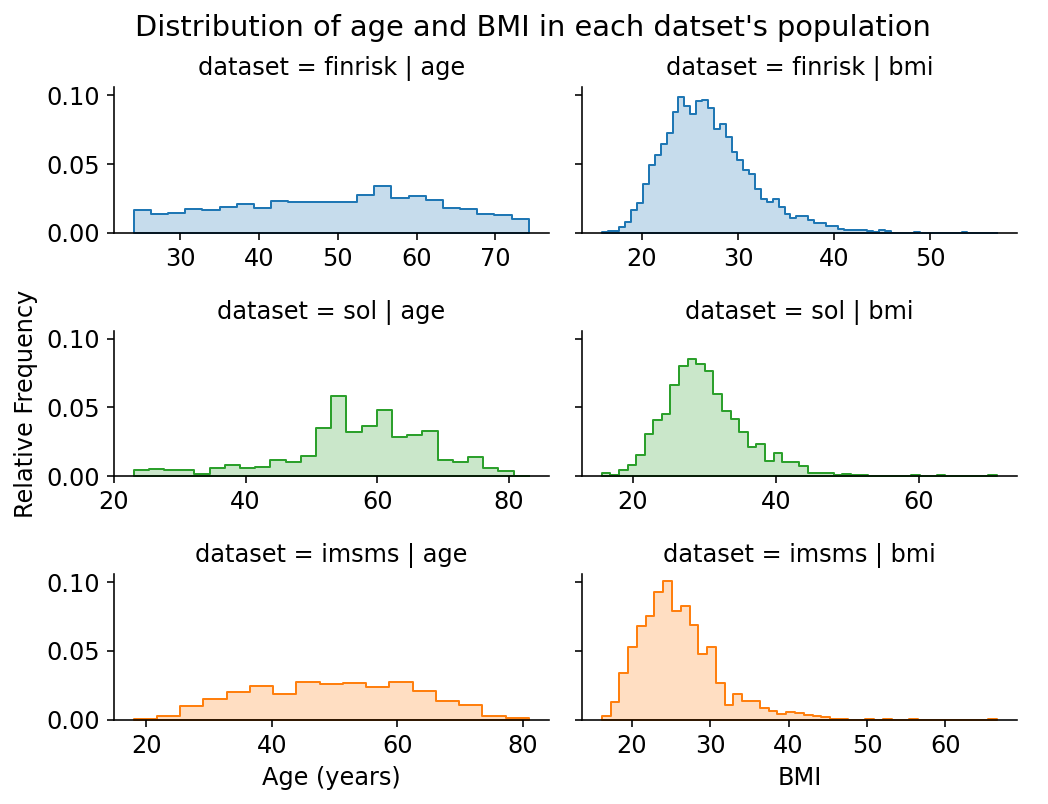

In [12]:
g = sns.FacetGrid(
    melted_metadata,  
    col="target", 
    row="dataset", 
    sharex=False,
    sharey=True,
    legend_out=True,
    height=1.75, aspect=2,
)
g.map_dataframe(
    sns.histplot, 
    x="target_value",
    hue="dataset", 
    hue_order=["finrisk", "imsms", "sol"],
    kde=False, 
    element="step",
    stat="density", 
    common_norm=False,
)
plt.xlabel("Relative Frequency") 
g.set_titles(col_template="{col_name}", row_template="dataset = {row_name}")
g.axes[2,0].set_xlabel('Age (years)')
g.axes[2,1].set_xlabel('BMI')
g.axes[1,0].set_ylabel('Relative Frequency')
g.add_legend()
plt.suptitle("Distribution of age and BMI in each datset's population", y=1.02)

In [13]:
df.groupby("dataset").var()

NameError: name 'df' is not defined

In [ ]:
df.groupby("dataset").count()

# Null models 
These null models use the mean/median over the whole dataset, not just the training set of each CV fold.
All cells below can be run without prior cells (except first two cells)

In [3]:
basedir = "/projects/ibm_aihl/ML-benchmark/processed/"
level = "MG"
canonical_targets = ["age", "bmi"]
md_MG = merge_normalize_metadata(basedir, level, canonical_targets)
md_MG["level"] = level

level = "16S"
canonical_targets = ["age", "bmi"]
md_16S = merge_normalize_metadata(basedir, level, canonical_targets)
md_16S["level"] = level

finrisk age 12.981947323882014
finrisk bmi 4.688509055862854
sol age 11.12747070499261
sol bmi 5.784031369150544
imsms age 12.544006509548986
imsms bmi 5.28216657056109
finrisk age 12.984428438908639
finrisk bmi 4.687526024825324
sol age 11.125794964736535
sol bmi 5.785418158675929
imsms age 12.583863483564011
imsms bmi 5.297300501256507


In [4]:
md_merged_level = pd.concat([md_16S, md_MG])
md_merged_level = md_merged_level[md_merged_level.dataset.notnull()]

In [6]:
class NormalNullifier(object):
    
    def __init__(self):
        self.mean = None
        self.sdev = None

    def fit(self, x, y):
        self.mean = np.mean(y)
        self.sdev = np.std(y)
        
    def predict(self, x):
        return np.random.normal(self.mean, self.sdev, x.shape[1]) 

        
class MeanNullifier(object):
    
    def __init__(self):
        self.mean = None

    def fit(self, x, y):
        self.mean = np.mean(y)
        
    def predict(self, x):
        return np.repeat(self.mean, x.shape[1])

    
class MedianNullifier(object):
    
    def __init__(self):
        self.median = None

    def fit(self, x, y):
        self.median = np.median(y)
        
    def predict(self, x):
        return np.repeat(self.median, x.shape[1])

In [7]:
def get_null_model_mae(Nullifier, merged_metadata):
    null_model_scores = {}

    for dataset, level in product(
        merged_metadata.dataset.unique(),
        merged_metadata.level.unique(),
    ):
        print(dataset, level)
        subset = merged_metadata.query(f"dataset=='{dataset}' and level=='{level}'")

        for target in ["age", "bmi"]:
            model = Nullifier()
            y = subset[target][subset[target].notnull()]
            model.fit(x=None, y=y)
            preds = model.predict(np.zeros(shape=(100, len(y))))
            mae_score = mae(y, preds)

            null_model_scores[f"{dataset}-{level}-{target}"] = mae_score
    return null_model_scores

def get_null_model_rmse(Nullifier, merged_metadata):
    null_model_scores = {}

    for dataset, level in product(
        merged_metadata.dataset.unique(),
        merged_metadata.level.unique(),
    ):
        print(dataset, level)
        subset = merged_metadata.query(f"dataset=='{dataset}' and level=='{level}'")

        for target in ["age", "bmi"]:
            model = Nullifier()
            y = subset[target][subset[target].notnull()]
            model.fit(x=None, y=y)
            preds = model.predict(np.zeros(shape=(100, len(y))))
            mae_score = rmse(y, preds)

            null_model_scores[f"{dataset}-{level}-{target}"] = mae_score
    return null_model_scores

In [8]:
get_null_model_mae(NormalNullifier, md_merged_level)

finrisk 16S
finrisk MG
sol 16S
sol MG
imsms 16S
imsms MG


{'finrisk-16S-age': 14.915587287181173,
 'finrisk-16S-bmi': 5.17230737288687,
 'finrisk-MG-age': 14.754344032009286,
 'finrisk-MG-bmi': 5.271166952851583,
 'sol-16S-age': 12.2729265315878,
 'sol-16S-bmi': 6.426263696865615,
 'sol-MG-age': 12.458588139812838,
 'sol-MG-bmi': 6.4775798522298205,
 'imsms-16S-age': 14.601543750954344,
 'imsms-16S-bmi': 5.911259926517631,
 'imsms-MG-age': 14.469238541458957,
 'imsms-MG-bmi': 5.836113140859608}

In [9]:
get_null_model_mae(MeanNullifier, md_merged_level)

finrisk 16S
finrisk MG
sol 16S
sol MG
imsms 16S
imsms MG


{'finrisk-16S-age': 11.008842899124199,
 'finrisk-16S-bmi': 3.6099480422729187,
 'finrisk-MG-age': 11.005676285051075,
 'finrisk-MG-bmi': 3.6101707963461864,
 'sol-16S-age': 8.431108447160375,
 'sol-16S-bmi': 4.377404699308495,
 'sol-MG-age': 8.437699409189808,
 'sol-MG-bmi': 4.377604496353603,
 'imsms-16S-age': 10.656447239656677,
 'imsms-16S-bmi': 3.9038037621349866,
 'imsms-MG-age': 10.617623615110315,
 'imsms-MG-bmi': 3.8993660237105168}

In [10]:
get_null_model_mae(MedianNullifier, md_merged_level)

finrisk 16S
finrisk MG
sol 16S
sol MG
imsms 16S
imsms MG


{'finrisk-16S-age': 10.979746500777605,
 'finrisk-16S-bmi': 3.573352970049782,
 'finrisk-MG-age': 10.976349626400996,
 'finrisk-MG-bmi': 3.5734209440781686,
 'sol-16S-age': 8.405445180279617,
 'sol-16S-bmi': 4.330821549940959,
 'sol-MG-age': 8.411290322580646,
 'sol-MG-bmi': 4.329213378962472,
 'imsms-16S-age': 10.649955237242613,
 'imsms-16S-bmi': 3.838911254592659,
 'imsms-MG-age': 10.608733624454148,
 'imsms-MG-bmi': 3.836397494803494}

The above dictionaries can be mapped to files

# Sample count for each dataset/cohort

In [11]:
dataset_sizes = {}

for dataset, level in product(
    md_merged_level.dataset.unique(),
    md_merged_level.level.unique(),
):
    subset = md_merged_level.query(
        f"dataset=='{dataset}' and level=='{level}' "
    )
    
    for target in ["age", "bmi"]:
        subsubset = subset[target][subset[target].notnull()]
        dataset_sizes[f"{dataset}-{level}-{target}"] = subsubset.shape[0]
dataset_sizes

{'finrisk-16S-age': 6430,
 'finrisk-16S-bmi': 6428,
 'finrisk-MG-age': 6424,
 'finrisk-MG-bmi': 6422,
 'sol-16S-age': 1359,
 'sol-16S-bmi': 1355,
 'sol-MG-age': 1364,
 'sol-MG-bmi': 1359,
 'imsms-16S-age': 1117,
 'imsms-16S-bmi': 1117,
 'imsms-MG-age': 1145,
 'imsms-MG-bmi': 1145}

# Null model and standard deviation for each CV fold
These null models use the mean/median of the training set of each CV fold.

In [16]:
datasets_to_target = {
    "finrisk": ["BL_AGE", "BMI"],
    "sol": ["age_v2", "bmi_v2"],
    "imsms": ["age", "bmi"],
}
target_mapping = {
    'age_v2': 'age',
    'BL_AGE': 'age',
    'bmi_v2': 'bmi',
    'BMI': 'bmi',
    'bmi': 'bmi',
    'age': 'age'
}
canonical_targets = {'bmi', 'age'}
TARGET_SD = {}
NULL_MEANMODEL_MAE = {}
NULL_MEDIANMODEL_MAE = {}
    
for dataset in datasets_to_target:   
        for target in datasets_to_target[dataset]:
            for level in ["MG", "16S"]:

                table = Artifact.load(
                    os.path.join(basedir, f"{dataset}/{level}/{target}/filtered_rarefied_table.qza")
                ).view(biom.Table)

                metadata = Artifact.load(
                    os.path.join(basedir, f"{dataset}/{level}/{target}/filtered_metadata.qza")
                ).view(pd.Series)

                worker = RegressionTask(
                    table, # This is arbitrary, since we don't use the actual model
                    metadata,
                    algorithm="RandomForestRegressor", # This is arbitrary, since we don't use the actual model
                    params="{}", # This is arbitrary, since we don't use the actual model
                    n_repeats=3, # We use 3x repeated stratified CV.
                )

                canon_target = target_mapping[target]
                total_y_stdev = np.std(worker.y, ddof=1) # sample stdev
                print(f"{dataset}/{level}/{canon_target}/{total_y_stdev}")
                
                CV_IDX = 0
                for train_index, test_index in worker.splits:
                    X_train = worker.X[train_index]
                    y_train = worker.y[train_index]
                    y_test = worker.y[test_index]
                    
                    stdev = np.std(y_train, ddof=1) # sample stdev
                    TARGET_SD[f"({dataset}, {canon_target}, {level}, {CV_IDX})"] = stdev
                    
                    # Predict mean of training set 
                    null_mean_predictions = [np.mean(y_train)]*len(y_test)
                    null_mean_mae = mae(y_test, null_mean_predictions)
                    NULL_MEANMODEL_MAE[f"({dataset}, {canon_target}, {level}, {CV_IDX})"] = null_mean_mae
                    # Predict median of training set
                    null_median_predictions = [np.median(y_train)]*len(y_test)
                    null_median_mae = mae(y_test, null_median_predictions)
                    NULL_MEDIANMODEL_MAE[f"({dataset}, {canon_target}, {level}, {CV_IDX})"] = null_median_mae
                    
                    CV_IDX += 1

{}
finrisk/MG/age/12.982957867403094


/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{}
finrisk/16S/age/12.985438232310553
{}
finrisk/MG/bmi/4.688874133461683


/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{}
finrisk/16S/bmi/4.6878906851413165


/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{}
sol/MG/age/11.131551934069869
{}
sol/16S/age/11.129890600790866


/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)

{}
sol/MG/bmi/5.7861605911513045
{}
sol/16S/bmi/5.787554181698192
{}
imsms/MG/age/12.549487832296728


/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{}
imsms/16S/age/12.589500152820284
{}
imsms/MG/bmi/5.284470678225985
{}
imsms/16S/bmi/5.299669068556288


/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/pmcgrath/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)

In [14]:
TARGET_SD

{'(finrisk, age, MG, 0)': 12.9826275251222,
 '(finrisk, age, MG, 1)': 12.982532006554512,
 '(finrisk, age, MG, 2)': 12.98256602827878,
 '(finrisk, age, MG, 3)': 12.982506284800023,
 '(finrisk, age, MG, 4)': 12.985819328357218,
 '(finrisk, age, MG, 5)': 12.982333744933946,
 '(finrisk, age, MG, 6)': 12.982583534350121,
 '(finrisk, age, MG, 7)': 12.982689402100606,
 '(finrisk, age, MG, 8)': 12.98249272389514,
 '(finrisk, age, MG, 9)': 12.985951640203048,
 '(finrisk, age, MG, 10)': 12.982315913042434,
 '(finrisk, age, MG, 11)': 12.982581323331077,
 '(finrisk, age, MG, 12)': 12.98252145017817,
 '(finrisk, age, MG, 13)': 12.982676309207388,
 '(finrisk, age, MG, 14)': 12.985956098363527,
 '(finrisk, age, 16S, 0)': 12.98578125329406,
 '(finrisk, age, 16S, 1)': 12.985686181796467,
 '(finrisk, age, 16S, 2)': 12.98546240328747,
 '(finrisk, age, 16S, 3)': 12.98583690302002,
 '(finrisk, age, 16S, 4)': 12.985686841649162,
 '(finrisk, age, 16S, 5)': 12.985716406685995,
 '(finrisk, age, 16S, 6)': 12.9

In [14]:
NULL_MEANMODEL_MAE

{'(finrisk, age, MG, 0)': 11.00758368711683,
 '(finrisk, age, MG, 1)': 11.007910901831801,
 '(finrisk, age, MG, 2)': 11.007948868914982,
 '(finrisk, age, MG, 3)': 11.007945404146062,
 '(finrisk, age, MG, 4)': 10.996985754027419,
 '(finrisk, age, MG, 5)': 11.00828423068274,
 '(finrisk, age, MG, 6)': 11.00773457719749,
 '(finrisk, age, MG, 7)': 11.00732735176112,
 '(finrisk, age, MG, 8)': 11.00797444884355,
 '(finrisk, age, MG, 9)': 10.997054089845692,
 '(finrisk, age, MG, 10)': 11.008633484841258,
 '(finrisk, age, MG, 11)': 11.007520721604758,
 '(finrisk, age, MG, 12)': 11.007969999765281,
 '(finrisk, age, MG, 13)': 11.007850731758285,
 '(finrisk, age, MG, 14)': 10.996399414524165,
 '(finrisk, age, 16S, 0)': 11.008592114746921,
 '(finrisk, age, 16S, 1)': 11.008754196406327,
 '(finrisk, age, 16S, 2)': 11.00964562739298,
 '(finrisk, age, 16S, 3)': 11.008345237260217,
 '(finrisk, age, 16S, 4)': 11.008877394793553,
 '(finrisk, age, 16S, 5)': 11.008854387119088,
 '(finrisk, age, 16S, 6)': 11

Finally, dump to JSON

In [18]:
with open("standard_deviations.json",  "w") as  f:
    json.dump(TARGET_SD, f, ensure_ascii=False, indent=4)
with open("null_mean_models.json",  "w") as  f:
    json.dump(NULL_MEANMODEL_MAE, f, ensure_ascii=False, indent=4)
with open("null_median_models.json",  "w") as  f:
    json.dump(NULL_MEDIANMODEL_MAE, f, ensure_ascii=False, indent=4)